In [15]:
import tensorflow as tf
import os
import numpy as np
import cv2
from scipy.misc import imsave

In [2]:
images = []
path='F:\\All247images\\images\\'
for i in range(246):
    name= path+str(i)+".png"
    print(name)
    # read the jpg file
    ds = cv2.imread(name)
    #ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    images += [ds]
class AELikeModel:
    """
    AE-like Model with Pooling as a Size-changing Factor
    """
    def __init__(self, image_size, alpha, verbose=False, trained_model=None):
        tf.reset_default_graph()
        self.image_size = image_size
        self.alpha = alpha
        self.verbose = verbose
        self.X = tf.placeholder(tf.float32, [None, self.image_size, self.image_size, 1])
        self.Y_clear = tf.placeholder(tf.float32, [None, self.image_size, self.image_size, 1])

        n_filters = [16, 32, 64]
        filter_sizes = [5, 5, 5]

        n_input = 1

        Ws = []
        shapes = []

        current_input = self.X
        for layer_i, n_output in enumerate(n_filters):
            with tf.variable_scope("encoder/layer/{}".format(layer_i)):
                shapes.append(current_input.get_shape().as_list())
                W = tf.get_variable(
                    name='W',
                    shape=[
                        filter_sizes[layer_i],
                        filter_sizes[layer_i],
                        n_input,
                        n_output],
                    initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
                h = tf.nn.conv2d(current_input, W,
                    strides=[1, 1, 1, 1], padding='SAME')
                conv = tf.nn.relu(h)
                current_input = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding='SAME')
                Ws.append(W)
                n_input = n_output
        Ws.reverse()
        shapes.reverse()
        n_filters.reverse()
        n_filters = n_filters[1:] + [1]

        for layer_i, shape in enumerate(shapes):
            with tf.variable_scope("decoder/layer/{}".format(layer_i)):
                W = Ws[layer_i]
                h = tf.nn.conv2d_transpose(current_input, W,
                    tf.stack([tf.shape(self.X)[0], shape[1], shape[2], shape[3]]),
                    strides=[1, 2, 2, 1], padding='SAME')
                current_input = tf.nn.relu(h)

        self.Y = current_input

        # MSE
        self.mse = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(self.Y_clear, self.Y), 1))
        # MS SSIM
        self.ssim = tf.reduce_mean(1 - tf.image.ssim_multiscale(self.Y_clear, self.Y, 1))
        # Mixed cost
        self.cost = self.alpha*self.ssim + (1 - self.alpha)*self.mse
# Using Adam for optimizer
        self.learning_rate = tf.Variable(initial_value=1e-2, trainable=False, dtype=tf.float32)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        self.batch_size = tf.Variable(initial_value=64, trainable=False, dtype=tf.int32)
        self.trained_model = trained_model
    def init_session(self):
        """
        Init session
        """
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        saver = tf.train.Saver()
        coord = tf.train.Coordinator()
        _ = tf.train.start_queue_runners(sess=sess, coord=coord)

        if not self.trained_model is None:
            saver.restore(sess, self.trained_model)
        return (sess,saver)
def train(self, x_path_dir, y_path_dir, epochs, train_steps, learning_rate, epochs_to_reduce_lr, reduce_lr, output_model, output_log, b_size):
        """
        Train data
        """
        # Check output directory
        check_and_create_dir(output_model)

        # Load data
        x_filenames = extract_image_path(["E:\ttest"])
        y_filenames = extract_image_path(["E:\train"])

        # Scalar
        tf.summary.scalar('Learning rate', self.learning_rate)
        tf.summary.scalar('MSE', self.mse)
        tf.summary.scalar('MS SSIM', self.ssim)
        tf.summary.scalar('Loss', self.cost)
        tf.summary.image('BSE', self.Y)
        tf.summary.image('Ground truth', self.Y_clear)
        merged = tf.summary.merge_all()

        sess, saver = self.init_session()
        writer = tf.summary.FileWriter(output_log, sess.graph)

        l_rate = learning_rate
        try:
            for epoch_i in range(epochs):
                if ((epoch_i + 1) % epochs_to_reduce_lr) == 0:
                    l_rate = l_rate * (1 - reduce_lr)
                if self.verbose:
                    print("\n------------ Epoch : ",epoch_i+1)
                    print("Current learning rate {}".format(l_rate))

                # Training steps
                for i in range(train_steps):
                    if self.verbose:
                        print_train_steps(i+1, train_steps)
                    x_batch, y_batch = get_batch(b_size, self.image_size, x_filenames, y_filenames)

                    sess.run(self.optimizer, feed_dict={ self.X: x_batch, self.Y_clear: y_batch, self.learning_rate: l_rate, self.batch_size: b_size })
                    if i % 50 == 0:
                        summary = sess.run(merged, {self.X: x_batch, self.Y_clear: y_batch, self.learning_rate: l_rate, self.batch_size: b_size})
                        writer.add_summary(summary, i+ epoch_i*train_steps)
                if self.verbose:
                    print("\nSave model to {}".format(output_model))
                saver.save(sess, output_model, global_step=(epoch_i+1)*train_steps)
        except KeyboardInterrupt:
            saver.save(sess, output_model)

def test(self, input_image, output_image):
        '''
        Test image
        '''
        img = extract_n_normalize_image(input_image)
        x_image = np.reshape(np.array([img]), (1, self.image_size, self.image_size, 1))
        sess, _ = self.init_session()
        y_image = sess.run(self.Y, feed_dict={self.X: x_image})
        encoded_image = y_image.reshape((self.image_size, self.image_size))
        imsave(output_image, encoded_image)    

F:\All247images\images\0.png
F:\All247images\images\1.png
F:\All247images\images\2.png
F:\All247images\images\3.png
F:\All247images\images\4.png
F:\All247images\images\5.png
F:\All247images\images\6.png
F:\All247images\images\7.png
F:\All247images\images\8.png
F:\All247images\images\9.png
F:\All247images\images\10.png
F:\All247images\images\11.png
F:\All247images\images\12.png
F:\All247images\images\13.png
F:\All247images\images\14.png
F:\All247images\images\15.png
F:\All247images\images\16.png
F:\All247images\images\17.png
F:\All247images\images\18.png
F:\All247images\images\19.png
F:\All247images\images\20.png
F:\All247images\images\21.png
F:\All247images\images\22.png
F:\All247images\images\23.png
F:\All247images\images\24.png
F:\All247images\images\25.png
F:\All247images\images\26.png
F:\All247images\images\27.png
F:\All247images\images\28.png
F:\All247images\images\29.png
F:\All247images\images\30.png
F:\All247images\images\31.png
F:\All247images\images\32.png
F:\All247images\imag

In [3]:
from __future__ import division
from configparser import ConfigParser
import argparse
import imreg_dft as ird
import os
import cv2
from scipy.misc import imsave
from multiprocessing.pool import Pool
from itertools import product
import numpy as np

def similarity(params):
    
    # The template
    source_image, target_image, size, source_out_dir, target_out_dir, verbose = params
    im0 = extract_n_preprocess_dicom(source_image, size)
    # The image to be transformed
    im1 = extract_n_preprocess_dicom(target_image, size)

    filename = os.path.basename(os.path.normpath(source_image))
    if verbose: print("Comparing %r .........." % filename)
    # Transform im1 to im0
    result = ird.similarity(im0, im1, numiter=3)
    source_image_path = os.path.join(source_out_dir, filename)
    target_image_path = os.path.join(target_out_dir, filename)
    if verbose: print("Saving %r .........." % source_image_path)
    imsave(source_image_path, im0)
    imsave(target_image_path, result['timg'])
    if verbose: print("Saved %r .........." % source_image_path)

def get_image_path_from(source_dir, target_dir):
    """
    Get image paths from source and target directory
    """
    source_images = extract_image_path(["F:\\all247images\\"])
    target_images = extract_image_path(["F:\\target"])

    assert len(source_images) == len(target_images), "Number of images in %r is not the same as %r" % (source_dir, target_dir)
    return (source_images, target_images)

def check_n_create_output_dir(output_dir):
    """
    Check and create output directory
    """
    source_out_dir = os.path.join(output_dir, "source")
    target_out_dir = os.path.join(output_dir, "target")
    check_and_create_dir(source_out_dir)
    check_and_create_dir(target_out_dir)
    return (source_out_dir, target_out_dir)

def registration(verbose, num_threads, size, source_dir, target_dir, output_dir):
    """
    Registrating images and save to output_dir
    """
    if verbose: print("Get image paths ...")
    # Get images paths
    source_images, target_images = get_image_path_from(source_dir, target_dir)

    # Check and create output directory
    source_out_dir, target_out_dir = check_n_create_output_dir(output_dir)

    pool = None
    if num_threads >= 1:
        pool = Pool(num_threads)
    else:
        pool = Pool()
    job_args = [(source_images[i], target_images[i], size, source_out_dir, target_out_dir, verbose) for i in range(len(source_images))]
    pool.map(similarity, job_args)
    pool.close()
    pool.join()

def augmentation_pair(params):
    """
    Augmenting pair of images
    """
    source_image_path, target_image_path, size, source_out_path, target_out_path, verbose = params
    source_image = extract_image(source_image_path)
    target_image = extract_image(target_image_path)
    filename = os.path.basename(os.path.normpath(source_image_path))
    if verbose:
        print("Augmenting image %r ..." % filename)
    augment_image_pair(source_image, target_image, size, source_out_path, target_out_path)
    if verbose:
        print("Augmented image %r ..." % filename)

def augmentation(verbose, num_threads, source_dir, target_dir, augmentation_seed, size, output_dir):
    """
    Augment registered images and save to output_dir
    """
    # Get images paths
    if verbose: print("Get image paths ...")
    source_images, target_images = get_image_path_from(source_dir, target_dir)

    # Check and create output directory
    source_out_dir, target_out_dir = check_n_create_output_dir(output_dir)

    # Augmenting images
    pool = None
    if num_threads >= 1:
        pool = Pool(num_threads)
    else:
        pool = Pool()
    job_args = []
    for seed in range(augmentation_seed):
        for i in range(len(source_images)):
            image_name = '%r_%r.png' % (seed, i)
            source_out_path = os.path.join(source_out_dir, image_name)
            target_out_path = os.path.join(target_out_dir, image_name)
            job_args.append((source_images[i], target_images[i], size, source_out_path, target_out_path, verbose))
    pool.map(augmentation_pair, job_args)
    pool.close()
    pool.join()

def main(args):
    cp = ConfigParser()
    cp.read(args.config)

    verbose = cp["DATA"].getboolean("verbose")
    num_threads = cp["DATA"].getint("num_threads")
    image_size = cp["DATA"].getint("image_size")

    # Data registration
    source_dir = cp["REGISTRATION"].get("source_dir")
    target_dir = cp["REGISTRATION"].get("target_dir")
    output_dir = cp["REGISTRATION"].get("registered_output_dir")
    is_registration = cp["REGISTRATION"].getboolean("data_registration")
    if is_registration:
        if verbose: print("Starting registration data ...")
        registration(verbose, num_threads, image_size, source_dir, target_dir, output_dir)

    # Data augmentation
    source_dir = cp["AUGMENTATION"].get("source_dir")
    target_dir = cp["AUGMENTATION"].get("target_dir")
    output_dir = cp["AUGMENTATION"].get("augmented_output_dir")
    augmentation_seed = cp["AUGMENTATION"].getint("augmentation_seed")
    is_augmentation = cp["AUGMENTATION"].getboolean("data_augmentation")
    if is_augmentation:
        if verbose: print("Starting augmentation data ...")
        augmentation(verbose, num_threads, source_dir, target_dir, augmentation_seed, image_size, output_dir)

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='hmchuong - BoneSuppression v2 - Preprocessing data')
    parser.add_argument('--config', default='config/data_preprocessing.cfg', type=str, help='config file')
    args = parser.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] [--config CONFIG]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\new\AppData\Roaming\jupyter\runtime\kernel-a2852e5a-12f7-4b08-974d-7e6dde72de99.json


SystemExit: 2

C:\Users\new\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
from __future__ import division
from configparser import ConfigParser
import argparse
#from model import AELikeModel

def main(args):
    # parser config
    cp = ConfigParser()
    cp.read(args.config)

    # Parse arguments
    image_size = cp["TRAIN"].getint("image_size")
    alpha = cp["TRAIN"].getfloat("alpha")
    use_trained_model = cp["TRAIN"].getboolean("use_trained_model")
    source_folder = cp["TRAIN"].get("source_folder")
    target_folder = cp["TRAIN"].get("target_folder")
    epochs = cp["TRAIN"].getint("epochs")
    train_steps = cp["TRAIN"].getint("train_steps")
    learning_rate = cp["TRAIN"].getfloat("learning_rate")
    epochs_to_reduce_lr = cp["TRAIN"].getint("epochs_to_reduce_lr")
    reduce_lr = cp["TRAIN"].getfloat("reduce_lr")
    output_model = cp["TRAIN"].get("output_model")
    output_log = cp["TRAIN"].get("output_log")
    batch_size = cp["TRAIN"].getint("batch_size")
    verbose = cp["TRAIN"].getboolean("verbose")

    # Training
    trained_model = None
    if use_trained_model:
        trained_model = cp["TRAIN"].get("trained_model")
    model = AELikeModel(image_size, alpha,verbose, trained_model)
    model.train(source_folder, target_folder, epochs, train_steps, learning_rate, epochs_to_reduce_lr, reduce_lr, output_model, output_log, batch_size)

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='hmchuong - BoneSuppression v2 - Training')
    parser.add_argument('--config', default='config/train.cfg', type=str, help='config file')
    args = parser.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] [--config CONFIG]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\new\AppData\Roaming\jupyter\runtime\kernel-a2852e5a-12f7-4b08-974d-7e6dde72de99.json


SystemExit: 2

In [5]:
from __future__ import division
from configparser import ConfigParser
import argparse
#from model import AELikeModel

def main(args):
    # parser config
    cp = ConfigParser()
    cp.read(args.config)
    model_path= args.model
    input_image = args.input
    output_image = args.output
    image_size = cp["TRAIN"].getint("image_size")
    alpha = cp["TRAIN"].getfloat("alpha")
    model = AELikeModel(image_size, alpha,False, model_path)
    model.test(input_image, output_image)

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='hmchuong - BoneSuppression v2 - Testing')
    parser.add_argument('--model', default='model/model', type=str, help='model path')
    parser.add_argument('--config', default='config/train.cfg', type=str, help='model config')
    parser.add_argument('--input', default='test.png', type=str, help='input image')
    parser.add_argument('--output', default='output.png', type=str, help='output image')
    args = parser.parse_args()
    main(args)

usage: ipykernel_launcher.py [-h] [--model MODEL] [--config CONFIG]
                             [--input INPUT] [--output OUTPUT]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\new\AppData\Roaming\jupyter\runtime\kernel-a2852e5a-12f7-4b08-974d-7e6dde72de99.json


SystemExit: 2

In [6]:
import numpy as np
import tensorflow as tf
import os
import cv2
from scipy.misc import imresize
from PIL import Image, ImageOps
import random
import sys
from sklearn.utils import shuffle

def crop_to_square(image, upsampling):
    """
    Crop image to square
    """
    if image.shape[0] == image.shape[1]:
        return image
    if upsampling:
        img = Image.fromarray(image)
        target_side = max(img.size)
        horizontal_padding = (target_side - img.size[0]) / 2
        vertical_padding = (target_side - img.size[1]) / 2
        start = [-horizontal_padding, -vertical_padding]
        width = img.size[0] + horizontal_padding
        height = img.size[1] + vertical_padding
    else:
        target_side = min(image.shape)
        horizontal_padding = int((image.shape[0] - target_side) / 2)
        vertical_padding = int((image.shape[1] - target_side) / 2)
        start = [horizontal_padding, vertical_padding]
        width = image.shape[0] - horizontal_padding
        height = image.shape[1] - vertical_padding
        return image[start[0]:width, start[1]:height]

    img = img.crop((start[0], start[1], width, height))
    return np.array(img)

def extract_n_preprocess_dicom(path, size):
    """
    Extract DICOM image from path with preprocessing to size
    """
    ds = cv2.imread(path)
    ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    ds = crop_to_square(ds, upsampling=True)
    ds = imresize(ds, (size,size), "lanczos")
    return ds

def extract_image(path):
    """
    Extract DICOM image from path
    """
    ds = cv2.imread(path)
    ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    return ds

def augment_image_pair(image1, image2, size, output_path1, output_path2):
    """
    Augment image pair
    """
    image1 = Image.fromarray(image1).convert('L')
    image2 = Image.fromarray(image2).convert('L')

    offset = random.randint(0, 100)
    rotate = random.randint(-30,30)
    min_val = random.randint(0, offset+1)

    # Flip
    if random.randint(1,3) % 2 == 0:
        image1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
        image2 = image2.transpose(Image.FLIP_LEFT_RIGHT)
    # Add offset
    image1 = ImageOps.expand(image1, offset)
    image2 = ImageOps.expand(image2, offset)
    # Rotate
    image1 = image1.rotate(rotate)
    image2 = image2.rotate(rotate)
    # Crop
    image1 = image1.crop((min_val, min_val, min_val+size, min_val+size))
    image2 = image2.crop((min_val, min_val, min_val+size, min_val+size))
    # Save
    image1.save(output_path1)
    image2.save(output_path2)

def extract_images(paths):
    """
    Extract images from paths
    """
    images = []
    for path in paths:
        ds = cv2.imread(path)
        ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
        images.append(ds)
    return images

def check_and_create_dir(dir_path):
    """
    Check and create directory path
    """
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

def extract_image_path(folders, extension="png"):
    """
    Extract image paths with extension from folders
    """
    images = []
    for folder in folders:
        for dirName, subdirList, fileList in os.walk(folder):
            for filename in fileList:
                if "." + extension in filename.lower():
                    images.append(os.path.join(dirName,filename))
    return images

def extract_n_normalize_image(path):
    """
    Extract DICOM image from path
    """
    ds = cv2.imread(path)
    ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    return ds.astype(float)/255
result = []
path='F:\\ribproject\\'
for i in range(246):
    final= path+str(i)+".png"
    print(final)
    # read the jpg file
    ds = cv2.imread(final)
    #ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    result += [ds]


def get_batch(batch_size, size, x_filenames, y_filenames):
    X, y = shuffle(x_filenames, y_filenames)
    X = X[:batch_size]
    y = y[:batch_size]
    X_images = []
    y_images = []
    for i in range(len(X)):
        X_images.append(extract_n_normalize_image(X[i]))
        y_images.append(extract_n_normalize_image(y[i]))
    X_images = np.reshape(np.array(X_images), (batch_size, size, size, 1))
    y_images = np.reshape(np.array(y_images), (batch_size, size, size, 1))
    return (X_images, y_images)
def print_train_steps(current_step, total_steps):
    point = int(current_step / (total_steps * 0.05))
    sys.stdout.write("\r[" + "=" * point +  " " * (20 - point) + "] ---- Step {}/{} ----- ".format(current_step, total_steps) +  str(int(float(current_step) * 100 / total_steps)) + "%")
    sys.stdout.flush()

F:\ribproject\0.png
F:\ribproject\1.png
F:\ribproject\2.png
F:\ribproject\3.png
F:\ribproject\4.png
F:\ribproject\5.png
F:\ribproject\6.png
F:\ribproject\7.png
F:\ribproject\8.png
F:\ribproject\9.png
F:\ribproject\10.png
F:\ribproject\11.png
F:\ribproject\12.png
F:\ribproject\13.png
F:\ribproject\14.png
F:\ribproject\15.png
F:\ribproject\16.png
F:\ribproject\17.png
F:\ribproject\18.png
F:\ribproject\19.png
F:\ribproject\20.png
F:\ribproject\21.png
F:\ribproject\22.png
F:\ribproject\23.png
F:\ribproject\24.png
F:\ribproject\25.png
F:\ribproject\26.png
F:\ribproject\27.png
F:\ribproject\28.png
F:\ribproject\29.png
F:\ribproject\30.png
F:\ribproject\31.png
F:\ribproject\32.png
F:\ribproject\33.png
F:\ribproject\34.png
F:\ribproject\35.png
F:\ribproject\36.png
F:\ribproject\37.png
F:\ribproject\38.png
F:\ribproject\39.png
F:\ribproject\40.png
F:\ribproject\41.png
F:\ribproject\42.png
F:\ribproject\43.png
F:\ribproject\44.png
F:\ribproject\45.png
F:\ribproject\46.png
F:\ribproject\47.png
F:

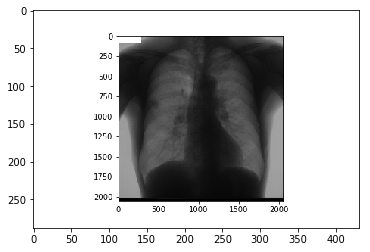

In [11]:
from matplotlib import pyplot as plt
plt.imshow(images[6])


In [8]:
path='F:\\ribproject\\'
result=[]
for i in range(246):
    name= path+str(i)+".png"
    print(name)
    # read the jpg file
    ds = cv2.imread(name)
    #ds = cv2.cvtColor(ds, cv2.COLOR_BGR2GRAY)
    result += [ds]

F:\ribproject\0.png
F:\ribproject\1.png
F:\ribproject\2.png
F:\ribproject\3.png
F:\ribproject\4.png
F:\ribproject\5.png
F:\ribproject\6.png
F:\ribproject\7.png
F:\ribproject\8.png
F:\ribproject\9.png
F:\ribproject\10.png
F:\ribproject\11.png
F:\ribproject\12.png
F:\ribproject\13.png
F:\ribproject\14.png
F:\ribproject\15.png
F:\ribproject\16.png
F:\ribproject\17.png
F:\ribproject\18.png
F:\ribproject\19.png
F:\ribproject\20.png
F:\ribproject\21.png
F:\ribproject\22.png
F:\ribproject\23.png
F:\ribproject\24.png
F:\ribproject\25.png
F:\ribproject\26.png
F:\ribproject\27.png
F:\ribproject\28.png
F:\ribproject\29.png
F:\ribproject\30.png
F:\ribproject\31.png
F:\ribproject\32.png
F:\ribproject\33.png
F:\ribproject\34.png
F:\ribproject\35.png
F:\ribproject\36.png
F:\ribproject\37.png
F:\ribproject\38.png
F:\ribproject\39.png
F:\ribproject\40.png
F:\ribproject\41.png
F:\ribproject\42.png
F:\ribproject\43.png
F:\ribproject\44.png
F:\ribproject\45.png
F:\ribproject\46.png
F:\ribproject\47.png
F:

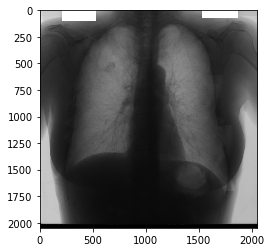

In [13]:
plt.imshow(result[5])